In [ ]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Install Catboost library
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib

In [ ]:
# Load the data
fatigue_df = pd.read_csv("/content/drive/MyDrive/Datasets/Titanium_Alloy_PI.csv", encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,N,O,H,Fe,Si,Sn,Nb,Mo,Zr,PI Fatigue Life
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0,1.199845e+05
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0,1.414165e+05
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0,3.316557e+05
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0,4.734918e+05
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0,2.211821e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,1.801202e+02
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,2.168016e+02
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,2.488141e+02
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7,3.426198e+02


In [ ]:
fatigue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

In [ ]:
# Sort the data by ascending order of number of cycles
fatigue_df = fatigue_df.sort_values(by='Number of Cycles')

In [ ]:
from scipy import stats
def outliers(df1, level):

    # 1. temporary dataframe
    df = df1.copy(deep = True)

    # 2. Select a level for a Z-score to identify and remove outliers
    df_Z = df[(np.abs(stats.zscore(df)) < level).all(axis=1)]
    ix_keep = df_Z.index

    # 3. Subset the raw dataframe with the indexes you'd like to keep
    df_keep = df.loc[ix_keep]

    return(df_keep)

In [ ]:
# Removing Outliers
out_df = outliers(fatigue_df, 3)

In [ ]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number']

# Use all remaining columns as features
features = out_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(out_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,N,O,H,Fe,Si,Sn,Nb,Mo,Zr,PI Fatigue Life
184,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.0025,0.00,0.004,0.0,0.340,4.00,0.70,0.500,3.70,1.428483e+02
79,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,1.331221e+02
83,700.06,1025,2.0,400,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,9.944032e+01
81,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,7.944426e+01
80,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.0020,0.09,0.000,0.0,0.305,4.02,0.71,0.505,3.54,2.796968e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,703.00,0,0.0,25,600,8.0,0.00,0.1,0.0,85.98,...,0.0040,0.03,0.008,0.0,0.000,1.95,0.00,2.000,3.80,2.137039e+07
42,947.76,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,2.925415e+07
43,846.12,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,5.087448e+07
39,695.53,0,0.0,25,800,2.0,0.00,0.1,6.0,84.83,...,0.0100,0.10,0.009,0.1,0.100,2.18,0.00,2.190,4.35,2.273788e+07


In [ ]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
        return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

q: 0.025 | pearsonr: 0.9450505953082116
q: 0.5 | pearsonr: 0.9522084758335793
q: 0.975 | pearsonr: 0.9125502835671649
Pearson CC: 0.9522084758335793
R2 score: 0.9066454434509943
RMSE: 0.49553548696385896
MAE: 0.34586149597533034
Coverage: 72.97297297297297
Interval Width: 0.8379246210995728
Composite Metric: 0.8456534903304315


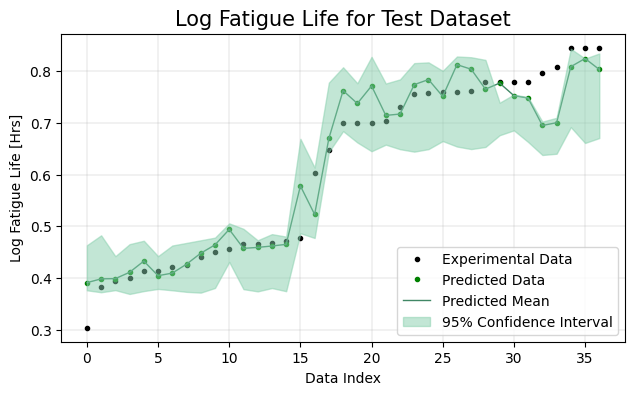

****************************************
q: 0.025 | pearsonr: 0.9671878235787177
q: 0.5 | pearsonr: 0.9818045167021828
q: 0.975 | pearsonr: 0.950642745747643
Pearson CC: 0.9818045167021828
R2 score: 0.9619970577092671
RMSE: 0.3175334339925408
MAE: 0.2111306554924234
Coverage: 83.7837837837838
Interval Width: 0.7594915014304227
Composite Metric: 0.9575459852958373


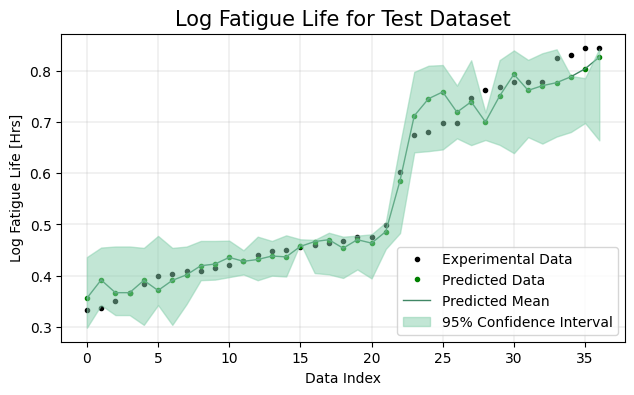

****************************************
q: 0.025 | pearsonr: 0.9481317944305038
q: 0.5 | pearsonr: 0.966106223013569
q: 0.975 | pearsonr: 0.9594753023449611
Pearson CC: 0.966106223013569
R2 score: 0.9240115025738362
RMSE: 0.5131003758033001
MAE: 0.30933008698896053
Coverage: 72.97297297297297
Interval Width: 1.9447029040813288
Composite Metric: 0.6758516381559073


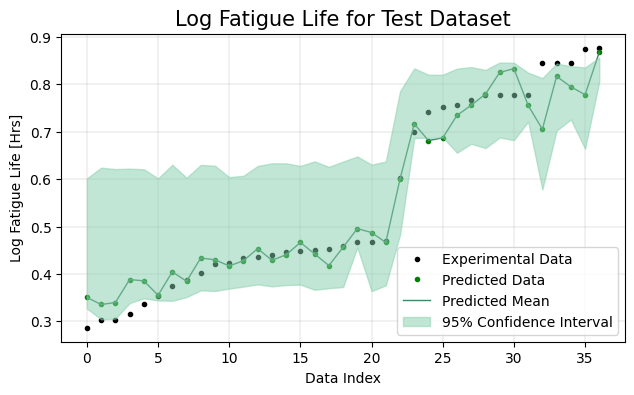

****************************************
q: 0.025 | pearsonr: 0.9659852856647347
q: 0.5 | pearsonr: 0.9854740140893665
q: 0.975 | pearsonr: 0.9395859738751687
Pearson CC: 0.9854740140893665
R2 score: 0.9703179765240252
RMSE: 0.29404353845051484
MAE: 0.19129491936452736
Coverage: 78.3783783783784
Interval Width: 0.7587681350393707
Composite Metric: 0.917319254432946


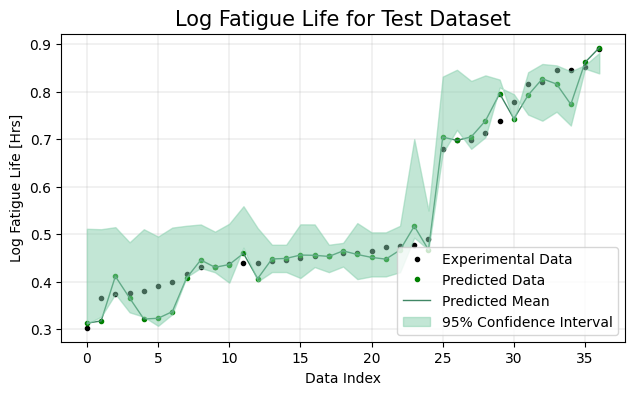

****************************************
q: 0.025 | pearsonr: 0.9581966390847523
q: 0.5 | pearsonr: 0.9793334679346544
q: 0.975 | pearsonr: 0.9465852108359576
Pearson CC: 0.9793334679346544
R2 score: 0.9355579342315297
RMSE: 0.43841752397027745
MAE: 0.2990643760182445
Coverage: 81.08108108108108
Interval Width: 1.0947305463149557
Composite Metric: 0.8364748060517632


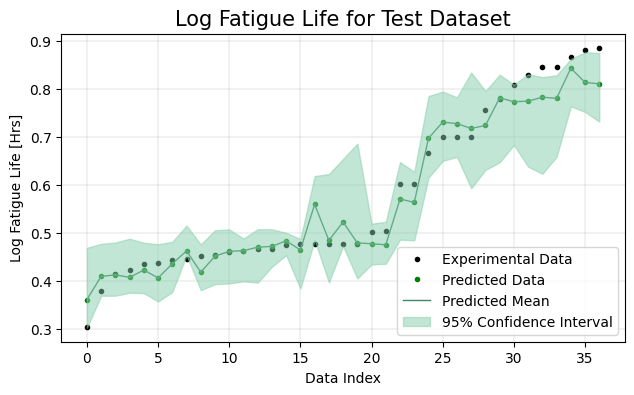

****************************************


In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

quantiles = [0.025, 0.5, 0.975]

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):
                X_train, X_test = features.iloc[tr], features.iloc[ts]
                scale = StandardScaler()
                X_train = scale.fit_transform(X_train)
                X_test = scale.transform(X_test)
                y_train, y_test = targets.iloc[tr], targets.iloc[ts]
                X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=0.1)

                for q in quantiles:
                        parameters = {'loss_function': 'Quantile:alpha={:0.2f}'.format(q),
                                'num_boost_round': 5000}
                        model = CatBoostRegressor(**parameters)
                        model.fit(X_train, np.log(y_train),
                                eval_set=[(X_val, np.log(y_val))],
                                early_stopping_rounds=20,
                                verbose=False)
                        y_pred = np.exp(model.predict(X_test))
                        print(f'q: {q} | pearsonr: {pearsonr(y_test, y_pred)[0]}')
                        if q==0.025:
                           y_low = y_pred
                        elif q==0.5:
                                y_median = y_pred
                        elif q==0.975:
                               y_high = y_pred

                PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_median))[0]
                R2_score[j, i] = r2_score(y_test, y_median)
                RMSE[j, i] = np.sqrt(mean_squared_error(y_test, y_median))
                MAE[j, i] = np.mean(abs(y_median-np.array(y_test)))

                print(f'Pearson CC: {PearsonCC[j, i]}')
                print(f'R2 score: {R2_score[j, i]}')
                print(f'RMSE: {RMSE[j, i]}')
                print(f'MAE: {MAE[j, i]}')

                test_coverage[j, i] = coverage(y_test, y_low, y_high)

                print(f'Coverage: {test_coverage[j, i]}')

                # Prediction interval width
                median_interval_width[j, i] = np.median(y_high - y_low)
                print(f'Interval Width: {median_interval_width[j, i]}')

                # Composite metric that combines the coverage and the invers of interval width
                composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
                print(f'Composite Metric: {composite_metric[j, i]}')

                # Plot the predictions
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

                iteration_list = [i for i in range(len(y_test))]
                ## Uncertainty quantification plot
                ax[0].plot(iteration_list, np.log10(y_test), 'ko', markersize=3, label="Experimental Data")
                ax[0].plot(iteration_list, np.log10(y_median), 'go', markersize=3, label="Predicted Data")
                ax[0].plot(iteration_list, np.log10(y_median), '-', linewidth=1, color="#408765", label="Predicted Mean")
                ax[0].fill_between(iteration_list, np.log10(y_low), np.log10(y_high), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
                ax[0].legend(loc=4, fontsize=10, frameon=True)
                ax[0].set_xlabel("Data Index", fontsize=10)
                ax[0].set_ylabel("Log Fatigue Life [Hrs]", fontsize=10)
                ax[0].set_title("Log Fatigue Life for Test Dataset", fontsize=15)
                ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
                fig.delaxes(ax[1])

                plt.show()
                print(40*'*')

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.952208,0.906645,0.495535,0.345861
1,0.981805,0.961997,0.317533,0.211131
2,0.966106,0.924012,0.513100,0.309330
3,0.985474,0.970318,0.294044,0.191295
4,0.979333,0.935558,0.438418,0.299064


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)


PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)


# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   },index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.972985,0.012272,0.939706,0.023624,0.411726,0.09026,0.271336,0.059662


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,72.972973,0.837925,0.845653
1,83.783784,0.759492,0.957546
2,72.972973,1.944703,0.675852
3,78.378378,0.758768,0.917319
4,81.081081,1.094731,0.836475


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,77.837838,4.324324,1.079124,0.449987,0.846569,0.096508
